In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt

# allow plots to appear directly in the notebook
%matplotlib inline

In [26]:
# read data into a DataFrame
df = pd.read_csv('Contributions_NY.csv', index_col=False)
spending = pd.read_csv('Campaign_Spending.csv', index_col=False) #will use this a bit later... 

In [27]:
df = df.drop(['cmte_id', 'receipt_desc', 'memo_cd', 'memo_text', 'form_tp', 'tran_id'], axis=1)
df.rename(columns={'election_tp': 'election_type'}, inplace=True)
df = df[df['contbr_employer'].notnull() & df['contbr_occupation'].notnull()]
df = df[df['election_type'] != np.NaN]
df = df[(df['contbr_employer'] != "INFORMATION REQUESTED") & (df['contbr_occupation'] != "INFORMATION REQUESTED")]

In [66]:
df.head(10)

,cand_id,cand_nm,contbr_nm,contbr_city,contbr_st,contbr_zip,contbr_employer,contbr_occupation,contb_receipt_amt,contb_receipt_dt,file_num,election_type,yearmonth,candidate_ord
1,P00003392,"Clinton, Hillary Rodham","CODY, ERIN",BUFFALO,NY,1.42222e+08,RUPP BAASE PFALZGRAF CUNNINGHAM LLC,ATTORNEY,66.95,2016-04-24,1091718,P2016,2016004,0
2,P60007168,"Sanders, Bernard","KEITH, SUSAN H",NEW YORK,NY,1.00133e+08,NOT EMPLOYED,NOT EMPLOYED,50.00,2016-03-06,1077404,P2016,2016003,1
3,P60007168,"Sanders, Bernard","LEPAGE, WILLIAM",BROOKLYN,NY,1.12381e+08,NEW YORK UNIVERSITY,UNDERGRADUATE ADMINISTRATOR,15.00,2016-03-04,1077404,P2016,2016003,1
5,P60007168,"Sanders, Bernard","LIEBER, MICHAEL",NEW HYDE PARK,NY,1.10402e+08,NYC BOARD OF ED,TEACHER,50.00,2016-03-05,1077404,P2016,2016003,1
8,P60007168,"Sanders, Bernard","LIEBERT, LYNN",PORT JEFFERSON,NY,1.17771e+08,SUNY,PROFESSOR,5.00,2016-03-05,1077404,P2016,2016003,1
9,P00003392,"Clinton, Hillary Rodham","KELLERMAN, ELYSSA",NEW YORK,NY,1.00124e+08,SELF-EMPLOYED,WILDLIFE PHOTOGAPHER,250.00,2016-04-19,1091718,P2016,2016004,0
11,P60007168,"Sanders, Bernard","LIEBERT, LYNN",PORT JEFFERSON,NY,1.17771e+08,SUNY,PROFESSOR,5.00,2016-03-05,1077404,P2016,2016003,1
12,P60007168,"Sanders, Bernard","LIU, IRENE",SYRACUSE,NY,1.32103e+08,LE MOYNE COLLEGE,PROFESSOR,5.00,2016-03-06,1077404,P2016,2016003,1
13,P60007168,"Sanders, Bernard","LIEBSON, AVRAM",HECTOR,NY,1.4842e+08,SELF EMPLOYED,GRAPHIC DESIGNER,150.00,2016-03-05,1077404,P2016,2016003,1
17,P60007168,"Sanders, Bernard","MCGIVNEY, DOUG",KINDERHOOK,NY,1.21062e+08,NONE,NOT EMPLOYED,41.00,2016-03-04,1077404,P2016,2016003,1


In [67]:
df.tail()

,cand_id,cand_nm,contbr_nm,contbr_city,contbr_st,contbr_zip,contbr_employer,contbr_occupation,contb_receipt_amt,contb_receipt_dt,file_num,election_type,yearmonth,candidate_ord
436467,P80001571,"Trump, Donald J.","DE GRAAF, JOHN",CAMBRIDGE,NY,12816,"FEDEX EXPRESS, INC.",PILOT,250.00,2016-07-23,1096341,G2016,2016007,2
436469,P00003392,"Clinton, Hillary Rodham","GELLER, KAREN",NEW YORK,NY,100213765,SELFHELP COMMUNITY SERVICES,NURSE ATTORNEY,19.00,2016-08-27,1100718,G2016,2016008,0
436470,P00003392,"Clinton, Hillary Rodham","WASHINGTON, DONETTE",SAINT ALBANS,NY,114122415,RABOBANK,"FINANCIAL MARKETS SERVICES MANAGER, VP",100.00,2016-08-07,1100718,G2016,2016008,0
436471,P00003392,"Clinton, Hillary Rodham","ALPERT, SANDRA",NEW YORK,NY,100232684,SELF-EMPLOYED,WRITER/EDITOR,25.00,2016-08-01,1100718,G2016,2016008,0
436472,P80001571,"Trump, Donald J.","MCCAULEY, KATHLEEN",NEW YORK,NY,10022,NYPD,POLICE OFFICER,33.25,2016-07-27,1096341,G2016,2016007,2


In [68]:
df.shape #look at the number of rows, columns in your dataset

(343412, 14)

In [31]:
df = df[df['cand_nm'].isin(['Trump, Donald J.','Clinton, Hillary Rodham','Sanders, Bernard'])]
df.contb_receipt_dt = pd.to_datetime(df.contb_receipt_dt,format='%Y-%m-%d') #cast as date 
df['yearmonth'] = df['contb_receipt_dt'].map(lambda x: 1000*x.year + x.month)

In [82]:
sum_df = df.groupby(['cand_nm', 'yearmonth'])['contb_receipt_amt'].sum()
pd.DataFrame(sum_df)

contb_receipt_amt
cand_nm                 yearmonth                   
Clinton, Hillary Rodham 2015004           2125050.72
                        2015005           1944752.17
                        2015006           2135995.45
                        2015007            618150.40
                        2015008           1137954.69
                        2015009           1459884.54
                        2015010           1291006.00
                        2015011           1185874.27
                        2015012           1231518.65
                        2016001           1429390.76
                        2016002           2840933.14
                        2016003           1984507.35
                        2016004           2414777.98
                        2016005           1701681.52
                        2016006           3489909.98
                        2016007           4003121.72
                        2016008           4906960.81
Sanders, Bernard        2015005              4200.00
                        2015006             16550.52
                        2015007            122119.36
                        2015008            136424.00
                        2015009            258705.84
                        2015010            277460.87
                        2015011            202495.41
                        2015012            441709.56
                        2016001            709309.97
                        2016002           1490231.40
                        2016003           1813228.50
                        2016004           1526573.27
                        2016005            883886.98
                        2016006            315424.84
                        2016007             61354.46
Trump, Donald J.        2015006             11400.00
                        2015007              9550.00
                        2015008             34647.77
                        2015009             16352.60
                        2015010              6548.18
                        2015011              4030.76
                        2015012             18786.82
                        2016001             13786.13
                        2016002             25821.13
                        2016003             52772.05
                        2016004             43136.23
                        2016005             71347.14
                        2016006            893660.68
                        2016007            634900.50
                        2016008            605815.19

In [83]:
sum_df = df.groupby(['cand_nm', 'yearmonth'])['contb_receipt_amt'].sum().reset_index(name='contb_receipt_amt') #sum
sum_df = sum_df[sum_df.yearmonth>2015000]

In [84]:
sum_df.head()

,cand_nm,yearmonth,contb_receipt_amt
0,"Clinton, Hillary Rodham",2015004,2125050.72
1,"Clinton, Hillary Rodham",2015005,1944752.17
2,"Clinton, Hillary Rodham",2015006,2135995.45
3,"Clinton, Hillary Rodham",2015007,618150.40
4,"Clinton, Hillary Rodham",2015008,1137954.69


In [71]:
sum_df.cand_nm.value_counts()

Clinton, Hillary Rodham    17
Trump, Donald J.           15
Sanders, Bernard           15
Name: cand_nm, dtype: int64

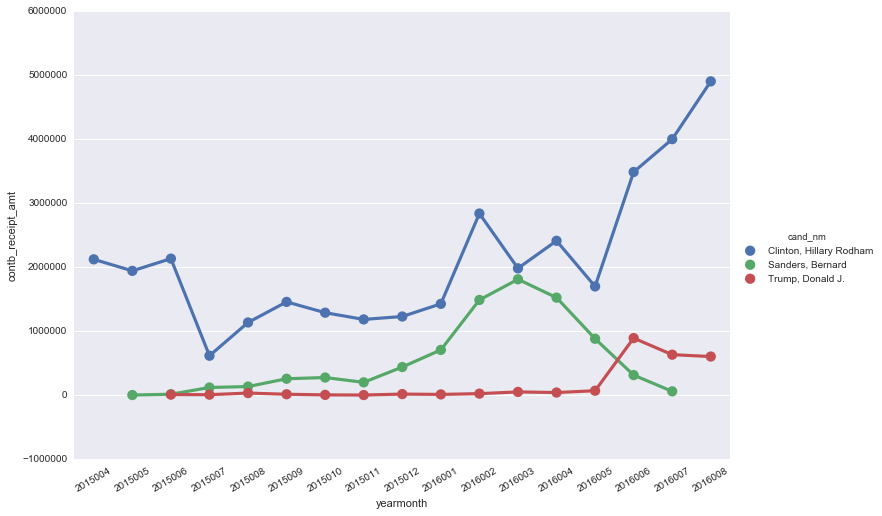

In [72]:
sns.set_style("darkgrid")
g = sns.factorplot(x="yearmonth", y="contb_receipt_amt", hue="cand_nm", data=sum_df, size=7, aspect=1.5)
g.set_xticklabels(rotation=30)

In [34]:
avg_df = df.groupby(['cand_nm', 'yearmonth'])['contb_receipt_amt'].mean().reset_index(name='contb_receipt_amt') #mean
avg_df = avg_df[avg_df.yearmonth>2015000]
avg_df = avg_df[avg_df['cand_nm'].isin(['Trump, Donald J.','Clinton, Hillary Rodham','Sanders, Bernard'])]
grouped_df = pd.merge(left=sum_df,right=avg_df, on = ['cand_nm','yearmonth'])

In [73]:
grouped_df.columns = ['cand_nm','yearmonth','contb_amt_total','contb_amt_avg']
grouped_df.head()

,cand_nm,yearmonth,contb_amt_total,contb_amt_avg
0,"Clinton, Hillary Rodham",2015004,2125050.72,1405.456825
1,"Clinton, Hillary Rodham",2015005,1944752.17,1525.295820
2,"Clinton, Hillary Rodham",2015006,2135995.45,1027.909264
3,"Clinton, Hillary Rodham",2015007,618150.40,572.361481
4,"Clinton, Hillary Rodham",2015008,1137954.69,689.669509


## Candidate Spending

In [36]:
spending = spending[spending['recipient_st']=='NY'] #limit to just NY state
spending.head()

,cmte_id,cand_id,cand_nm,recipient_nm,disb_amt,disb_dt,recipient_city,recipient_st,recipient_zip,disb_desc,memo_cd,memo_text,form_tp,file_num,tran_id,election_tp
10062,C00458844,P60006723,"Rubio, Marco",LOEWS HOTEL,195.59,09-JUN-15,NEW YORK,NY,10065,LODGING,X,NaN,SB23,1029436,SB17.I9301,NaN
10063,C00458844,P60006723,"Rubio, Marco",LOEWS HOTEL,58.99,09-JUN-15,NEW YORK,NY,10065,LODGING,X,NaN,SB23,1029436,SB17.I9302,NaN
10064,C00458844,P60006723,"Rubio, Marco",MILLENNIUM BROADWAY HOTEL,310.77,09-JUN-15,NEW YORK,NY,10036,LODGING,X,NaN,SB23,1029436,SB17.I9297,NaN
10065,C00458844,P60006723,"Rubio, Marco",MILLENNIUM BROADWAY HOTEL,310.77,09-JUN-15,NEW YORK,NY,10036,LODGING,X,NaN,SB23,1029436,SB17.I9298,NaN
10066,C00458844,P60006723,"Rubio, Marco",MILLENNIUM BROADWAY HOTEL,9.45,09-JUN-15,NEW YORK,NY,10036,LODGING,X,NaN,SB23,1029436,SB17.I9299,NaN


In [38]:
spending.cand_nm.value_counts() #number of rows for all candidates 

Clinton, Hillary Rodham      37863
Trump, Donald J.              3499
Sanders, Bernard              1067
Bush, Jeb                      336
Carson, Benjamin S.            321
Rubio, Marco                   276
Cruz, Rafael Edward 'Ted'      202
Graham, Lindsey O.             177
Paul, Rand                     136
Pataki, George E.              132
Kasich, John R.                128
Huckabee, Mike                 114
Christie, Christopher J.       105
Walker, Scott                  102
O'Malley, Martin Joseph         87
Fiorina, Carly                  62
Stein, Jill                     57
Johnson, Gary                   25
Perry, James R. (Rick)          20
Jindal, Bobby                   19
Webb, James Henry Jr.           17
Lessig, Lawrence                15
Santorum, Richard J.             2
Name: cand_nm, dtype: int64

In [39]:
spending.disb_dt = pd.to_datetime(spending.disb_dt,infer_datetime_format=True) #automatically detect and cast as date 
spending['yearmonth'] = spending['disb_dt'].map(lambda x: 1000*x.year + x.month)

In [40]:
grouped_amounts = spending.groupby(['cand_nm', 'yearmonth'])['disb_amt'].sum().reset_index(name='disb_amt')
grouped_amounts = grouped_amounts[grouped_amounts.yearmonth>2015000]
grouped_amounts.head()

In [41]:
grouped_amounts = grouped_amounts[grouped_amounts['cand_nm'].isin(['Trump, Donald J.','Clinton, Hillary Rodham','Sanders, Bernard'])]

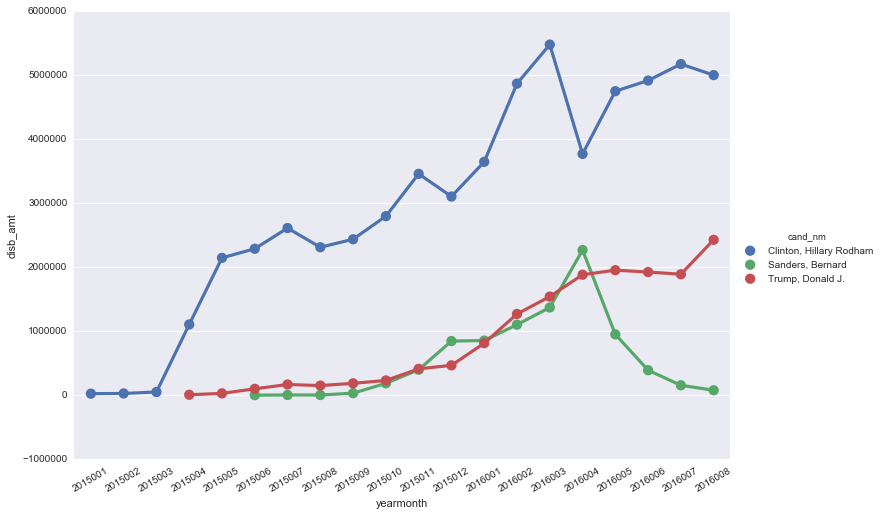

In [42]:
g = sns.factorplot(x="yearmonth", y="disb_amt", hue="cand_nm", data=grouped_amounts, size=7, aspect=1.5)
g.set_xticklabels(rotation=30)

In [74]:
grouped_df.head()

,cand_nm,yearmonth,contb_amt_total,contb_amt_avg
0,"Clinton, Hillary Rodham",2015004,2125050.72,1405.456825
1,"Clinton, Hillary Rodham",2015005,1944752.17,1525.295820
2,"Clinton, Hillary Rodham",2015006,2135995.45,1027.909264
3,"Clinton, Hillary Rodham",2015007,618150.40,572.361481
4,"Clinton, Hillary Rodham",2015008,1137954.69,689.669509


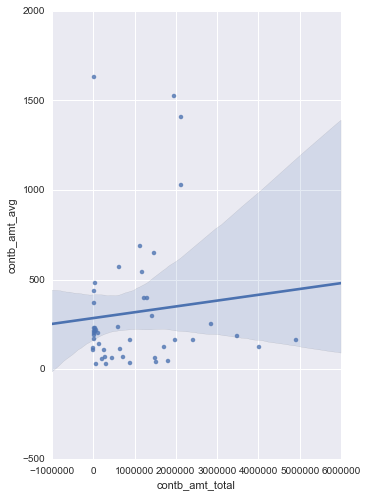

In [86]:
## plot to see if there's any linear relationship (answer: not rly, should log scale!)
sns.pairplot(grouped_df, x_vars=['contb_amt_total'], y_vars='contb_amt_avg', size=7, aspect=0.7, kind='reg')

## Merging the data together

In [46]:
## Combine two datasets together
alldata = pd.merge(left=grouped_df,right=grouped_amounts, on = ['cand_nm','yearmonth'])

In [52]:
alldata.head()

,cand_nm,yearmonth,contb_amt_total,contb_amt_avg,disb_amt
0,"Clinton, Hillary Rodham",2015004,2125050.72,1405.456825,1107071.18
1,"Clinton, Hillary Rodham",2015005,1944752.17,1525.295820,2148166.95
2,"Clinton, Hillary Rodham",2015006,2135995.45,1027.909264,2290710.47
3,"Clinton, Hillary Rodham",2015007,618150.40,572.361481,2613228.23
4,"Clinton, Hillary Rodham",2015008,1137954.69,689.669509,2313766.54


In [75]:
df.head()

,cand_id,cand_nm,contbr_nm,contbr_city,contbr_st,contbr_zip,contbr_employer,contbr_occupation,contb_receipt_amt,contb_receipt_dt,file_num,election_type,yearmonth,candidate_ord
1,P00003392,"Clinton, Hillary Rodham","CODY, ERIN",BUFFALO,NY,1.42222e+08,RUPP BAASE PFALZGRAF CUNNINGHAM LLC,ATTORNEY,66.95,2016-04-24,1091718,P2016,2016004,0
2,P60007168,"Sanders, Bernard","KEITH, SUSAN H",NEW YORK,NY,1.00133e+08,NOT EMPLOYED,NOT EMPLOYED,50.00,2016-03-06,1077404,P2016,2016003,1
3,P60007168,"Sanders, Bernard","LEPAGE, WILLIAM",BROOKLYN,NY,1.12381e+08,NEW YORK UNIVERSITY,UNDERGRADUATE ADMINISTRATOR,15.00,2016-03-04,1077404,P2016,2016003,1
5,P60007168,"Sanders, Bernard","LIEBER, MICHAEL",NEW HYDE PARK,NY,1.10402e+08,NYC BOARD OF ED,TEACHER,50.00,2016-03-05,1077404,P2016,2016003,1
8,P60007168,"Sanders, Bernard","LIEBERT, LYNN",PORT JEFFERSON,NY,1.17771e+08,SUNY,PROFESSOR,5.00,2016-03-05,1077404,P2016,2016003,1


## Some simple data analysis... 
See sklearn for more machine learning functions!

In [87]:
## Linear regression
feature_cols = ['contb_amt_avg','yearmonth']
X = alldata[feature_cols]
y = alldata.disb_amt

# instantiate and fit
lm1 = LinearRegression()
lm1.fit(X, y)

# print the coefficients
print lm1.intercept_
print lm1.coef_

-3659654629.06
[ 1058.96042769  1816.48550736]
